# Gridding Operations

In [1]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import h5py
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import scipy.interpolate

In [2]:
fires = pd.read_csv('../data/VIIRSNDE_global2018312.v1.0.txt')
fires.head()

,Lon,Lat,Mask,Conf,brt_t13(K),frp(MW),line,sample,Sat,YearDay,Hour
0,27.110006,30.769241,8,52,302.877533,5.814295,242,1735,NDE,2018312,1
1,26.083252,30.534357,9,100,332.959717,24.340988,301,1620,NDE,2018312,1
2,34.865997,28.162659,8,38,301.165985,6.107953,396,2589,NDE,2018312,1
3,34.872623,28.161121,8,71,307.277985,9.287819,396,2590,NDE,2018312,1
4,34.865070,28.158880,8,39,301.227783,6.001442,402,2590,NDE,2018312,1


In [3]:
# Number of nx and ny points for the grid. 720 nx, 360 ny creates a 1.0 degree grid
coverage = [-180.0, -90.0, 180.0, 90.0]

grid_size = 1.0

num_points_x = int(coverage[2] - coverage[0] / grid_size)
num_points_y = int(coverage[3] - coverage[1] / grid_size)

print(num_points_x, num_points_y)

360 180


In [4]:
# Using a real step length will skip the end value (exclusive)
print(np.mgrid[0:4:1.0])

[0. 1. 2. 3.]


In [5]:
#Using a complex number of bins will include the end value (inclusvie)
print(np.mgrid[0:4:5j])

[0. 1. 2. 3. 4.]


In [6]:
nx = complex(0, num_points_x)
ny = complex(0, num_points_y)
Xnew, Ynew = np.mgrid[coverage[0]:coverage[2]:nx, coverage[1]:coverage[3]:ny]

In [7]:
fire_count = np.zeros([num_points_x, num_points_y])

for i, lon in enumerate(fires.Lon):
    lat = fires.Lat[i]
    
    adjlat = ((lat + 90) / grid_size)
    adjlon = ((lon + 180) / grid_size)
    latbin = int(adjlat) 
    lonbin = int(adjlon)
    
    fire_count[lonbin, latbin] = fire_count[lonbin, latbin] + 1 
    

In [8]:
fire_count[fire_count == 0] = np.nan

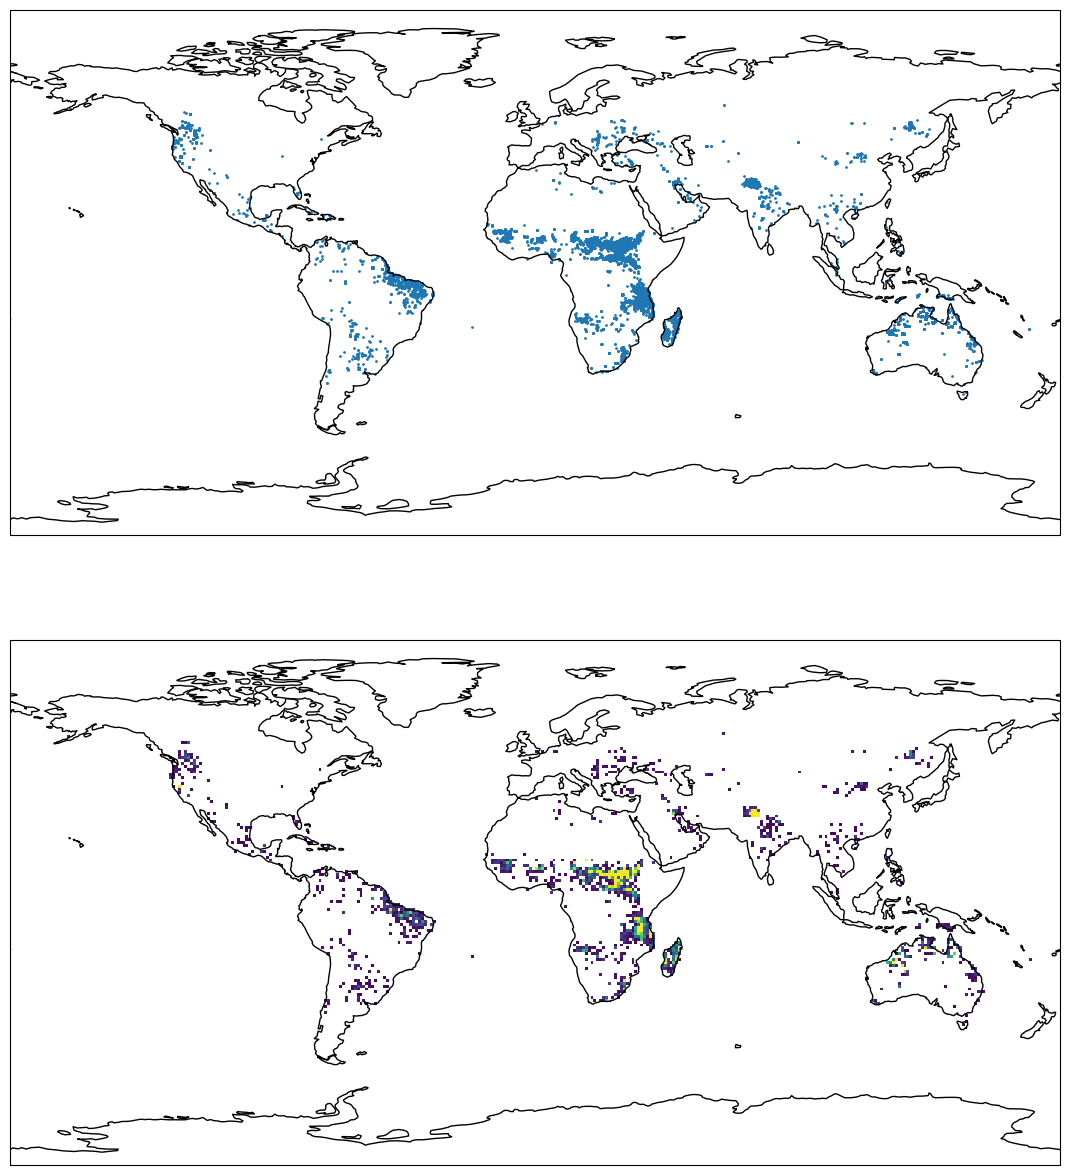

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[15,15], subplot_kw={'projection':ccrs.PlateCarree()})

ax1.coastlines()
ax1.set_global()

ax1.scatter(fires['Lon'], fires['Lat'], s=1)

ax2.coastlines()
ax2.set_global()

ax2.pcolormesh(Xnew, Ynew, fire_count, vmin=0, vmax=40)

plt.show()

In [12]:
fname = '../data/3B-HHR.MS.MRG.3IMERG.20160811-S233000-E235959.1410.V06B_thinned.HDF5'
imergv6 = h5py.File(fname, 'r')

In [15]:
precip = imergv6['Grid/precipitationCal'][0,:,:]
lat = imergv6['Grid/lat'][:]
lon = imergv6['Grid/lon'][:]

In [16]:
Xold, Yold = np.meshgrid(lon, lat, indexing='ij')

In [17]:
def create_2d_grid(grid_size):
    coverage = [-180.0, -90.0, 180.0, 90.0]
    
    num_points_x = int((coverage[2] - coverage[0]) / grid_size)
    num_points_y = int((coverage[3] - coverage[1]) / grid_size)
    
    nx = complex(0, num_points_x)
    ny = complex(0, num_points_y)
    
    Xnew, Ynew = np.mgrid[coverage[0]:coverage[2]:nx, coverage[1]:coverage[3]:ny]
    
    return Xnew, Ynew

In [18]:
Xnew, Ynew = create_2d_grid(0.5)

In [19]:
precip.shape, Yold.shape, Ynew.shape

((3600, 1800), (3600, 1800), (720, 360))

In [20]:
values = precip.flatten()

dims = (values.shape[0], 2)
points = np.zeros(dims)
points[:, 0] = Xold.flatten()
points[:, 1] = Yold.flatten()

In [21]:
gridOut = scipy.interpolate.griddata(points, values, (Xnew, Ynew), method='nearest')

/Users/justinreid/mambaforge/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


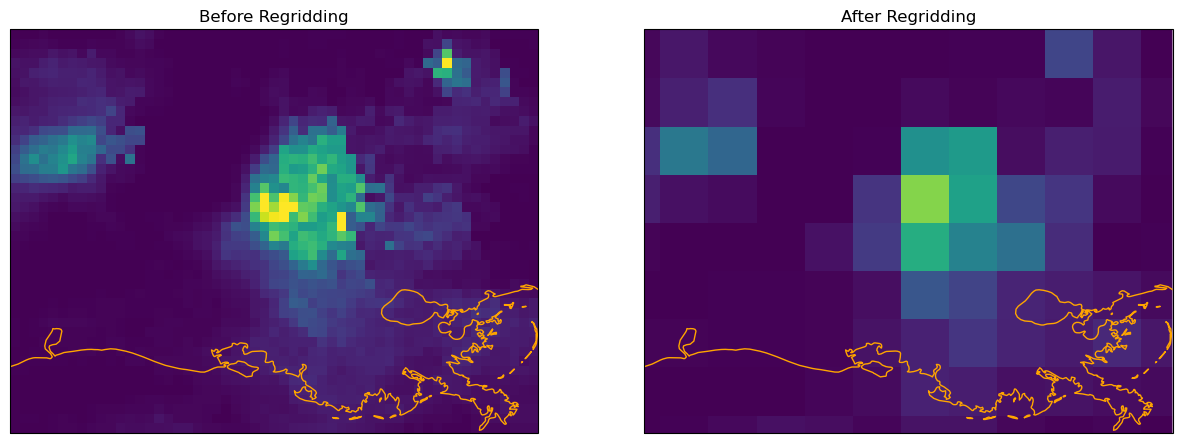

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=[15, 15], subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
    ax.set_extent([-94.3, -88.8, 28.9, 33.1])
    ax.coastlines('10m', color='orange')

axes[0].set_title('Before Regridding')
axes[0].pcolormesh(Xold, Yold, precip, vmin=0, vmax=20)

axes[1].set_title('After Regridding')
axes[1].pcolormesh(Xnew, Ynew, gridOut, vmin=0, vmax=20)

plt.show()